# GRU Model

In [1]:
import numpy as np
import pickle
import time
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from lstm_data_prep import numpy_prep
from eval_model import epoch_time, find_lens, accuracy

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
class GRU(nn.Module):
    def __init__(self, n_input, n_hidden, n_output, seq_length, num_layers = 1, drop = 0.1):
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.seq_length = seq_length
        self.num_layers = num_layers
        self.n_output = n_output
        
        super(GRU, self).__init__()
        self.dropout = nn.Dropout(drop)
        self.gru = nn.GRU(input_size=n_input, hidden_size=n_hidden, batch_first=True)
        self.fc = nn.Linear(n_hidden, n_output)
    
    def forward(self, x, x_len, h):
        x = torch.nn.utils.rnn.pack_padded_sequence(x, x_len, batch_first=True, enforce_sorted=False)
        output, hidden = self.gru(x, h)
    
        output, _ = torch.nn.utils.rnn.pad_packed_sequence(output, batch_first=True, padding_value=0.)

        output = output.contiguous().view(-1, self.seq_length, self.n_hidden)
        output = self.dropout(output)
        output = self.fc(output)
        output = output.view(-1, self.seq_length, self.n_output)
        
        return output, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.n_hidden, device=device)


In [3]:
class GRUModel:
    def __init__(self, model, loss_fn, optimizer, seq_len):
        self.model = model
        self.loss_fn = loss_fn
        self.optim = optimizer
        self.seq_len = seq_len

    def train(self, train_loader, n_epochs, learning):
        train_loss = []
        best_loss = 1e10

        self.model.train()
        for i in range(n_epochs):
            start = time.time()
            avg_loss = 0.
            for X, y in train_loader:
                loss = 0.
                curr_batch_size = X.shape[0]
                h = self.model.init_hidden(curr_batch_size)
                X, y = X.to(device), y.to(device)
                self.optim.zero_grad()

                X_lens = find_lens(X)

                output, h = self.model(X, X_lens, h)

                out = output.permute(0, 2, 1)
                target = y.permute(0, 2, 1)

                loss += self.loss_fn(out, target)
                
                loss.backward()
                self.optim.step()
                avg_loss += loss.item()

            end = time.time()
            epoch_mins, epoch_secs = epoch_time(start, end)
            if best_loss > avg_loss:
                best_loss = avg_loss
                torch.save({"gru": self.model.state_dict(), "gru_optimizer": self.optim.state_dict()}, 'gru-model.pt')

            print("Epoch " + str(i + 1) + "/" + str(n_epochs))
            print("Time: " + str(epoch_mins) + " minutes " + str(epoch_secs) + " seconds")
            print("Training loss: " + str(avg_loss))
            print()
            train_loss.append(avg_loss)
        return train_loss
    
    def eval(self, x, y):
        check = torch.load("gru-model.pt")
        self.model.load_state_dict(check["gru"])
        self.optim.load_state_dict(check["gru_optimizer"])

        with torch.no_grad():
            correct = np.zeros(self.seq_len)
            total = np.zeros(self.seq_len)
            self.model.eval()
            loss = 0.
            curr_batch_size = x.shape[0]
            h = self.model.init_hidden(curr_batch_size)
            X, Y = x.to(device), y.to(device)
            
            X_lens = find_lens(X)

            out, h = self.model(X, X_lens, h)

            top_value, top_index = out.topk(1)

            final = torch.zeros(y.shape).to(device)
            for clip in range(y.shape[0]):
                for step in range(y.shape[1]):
                    final[clip][step][top_index[clip][step]] = 1
                
            correct, total = accuracy(y.cpu().numpy(), final.cpu().numpy(), correct, total)
        
        ff_accuracy = correct / total
        return ff_accuracy, loss
    
    def random_samples(self, X, pad=0.):
        X_random = []
        X_lens = find_lens(X)
        for i in range(X.shape[0]):
            X_batch = np.random.normal(size=(X_lens[i], X.shape[-1]))
            if X_lens[i] < self.seq_len:
                X_pad = np.array([[pad]*X.shape[-1]]*(self.seq_len - X_lens[i]))
                X_batch = np.append(X_batch, X_pad, axis=0)
            X_random.append(X_batch)
        X_random = np.array(X_random)
        return X_random
    
    def rand_test(self, X, y_test, n_samples=20, percentile=90):
        rand_acc_array = []
        for sample in range(n_samples):
            X_random = torch.from_numpy(self.random_samples(X)).float().to(device)
            gru_rand_acc, _ = self.eval(X_random, y_test)
            rand_acc_array.append(gru_rand_acc)
        plot = np.percentile(np.sort(np.array(rand_acc_array), axis=0), percentile, axis=0)
        return plot

In [4]:
with open('HCP_movie_watching.pkl','rb') as f:
    TS = pickle.load(f)

X_train, y_train, X_t, y_t = numpy_prep(TS, pad = 0.)
batch_size = 32

train_data = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

X_test = torch.from_numpy(X_t).float().to(device)
y_test = torch.from_numpy(y_t).float().to(device)

c:\Users\Anna\Documents\GitHub\srp-lab-notebook\hcp_data\lstm_data_prep.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_padded = paddingArr(np.array(X_arr), pad=pad)


In [5]:
n_input = 300
n_hidden = 32
n_out = 15
n_layers = 1
seq_len = 90
drop = 0.1
EPOCHS = 15
learning_rate = 5e-3

gru = GRU(n_input, n_hidden, n_out, seq_len, n_layers, drop).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(gru.parameters(), lr=learning_rate)

model = GRUModel(gru, loss_fn, optimizer, seq_len)

In [46]:
#train_loss = model.train(train_loader, n_epochs=EPOCHS, learning=learning_rate)

Epoch 1/15
Time: 1 minutes 8 seconds
Training loss: 135.27332198619843

Epoch 2/15
Time: 1 minutes 14 seconds
Training loss: 109.94520854949951

Epoch 3/15
Time: 1 minutes 4 seconds
Training loss: 84.25413048267365

Epoch 4/15
Time: 1 minutes 5 seconds
Training loss: 63.523059248924255

Epoch 5/15
Time: 1 minutes 5 seconds
Training loss: 48.186941146850586

Epoch 6/15
Time: 1 minutes 6 seconds
Training loss: 40.66701450943947

Epoch 7/15
Time: 0 minutes 59 seconds
Training loss: 32.66582947969437

Epoch 8/15
Time: 1 minutes 5 seconds
Training loss: 26.83096244931221

Epoch 9/15
Time: 1 minutes 10 seconds
Training loss: 23.055525690317154

Epoch 10/15
Time: 1 minutes 7 seconds
Training loss: 22.633797109127045

Epoch 11/15
Time: 1 minutes 13 seconds
Training loss: 22.261797949671745

Epoch 12/15
Time: 1 minutes 16 seconds
Training loss: 20.944635838270187

Epoch 13/15
Time: 1 minutes 14 seconds
Training loss: 20.462711095809937

Epoch 14/15
Time: 1 minutes 10 seconds
Training loss: 18.7

In [6]:
gru_acc, loss = model.eval(X_test, y_test)
%store gru_acc

Stored 'gru_acc' (ndarray)


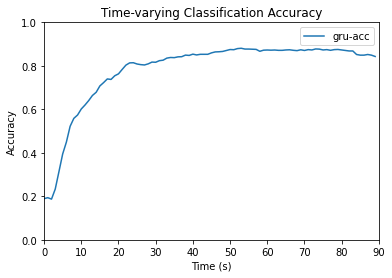

In [7]:
xAx = [i for i in range(0,90)]
plt.plot(xAx, gru_acc, label="gru-acc")
plt.xlabel("Time (s)")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.xlim(0,90)
plt.title("Time-varying Classification Accuracy")
plt.legend()
plt.show()